In [1]:
from datetime import datetime
import itertools
import glob
from pathlib import Path
import re


import numpy as np
import scipy.stats as st

import pandas as pd
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
npPath = Path('/sharedData/scratch/all_npy3/')
ncPath = Path('/sharedData/scratch/april_data/')
acmPath = Path('/sharedData/scratch/all_npy3/')
DATAPATH = Path('/sharedData/scratch/')

In [3]:
def data2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [4]:
def file2BT(npFile, ncFile):
    imageBox = np.load(npFile)   
    myFile = xr.open_dataset(ncFile)
    planck_fk1 = myFile['planck_fk1'].data
    planck_fk2 = myFile['planck_fk2'].data
    planck_bc1 = myFile['planck_bc1'].data                       
    planck_bc2 = myFile['planck_bc2'].data  
    return data2BT(imageBox.ravel(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

In [5]:
def jointplot(G17, G16, saveout):
    g = sns.jointplot(x= G17.squeeze(), y=G16.squeeze(), kind="reg", color="m")
    g.ax_joint.set_xlabel('G17')
    g.ax_joint.set_ylabel('G16')
    g.savefig(saveout)
    plt.close()
    return

In [6]:
def validation_plot(G17, G16, _G17n, _B, AUC, savepath):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (15,5))
    _ = ax1.plot(_G17n,_B, label=f"AUC: {AUC}")
    _ = ax1.set_ylabel('G16')
    _ = ax1.set_xlabel('G17')
    _ = ax1.set_title('Transform of G17 to G16')
    _ = ax1.set_aspect('equal')
    _ = ax1.legend(loc = 'upper left')

    _ = ax2.scatter(G17, G16)
    _ = ax2.set_ylabel('G16')
    _ = ax2.set_xlabel('G17')
    _ = ax2.set_title(f'G17 vs. G16 @{tSplice}')
    _ = ax2.set_aspect('equal')

    #_ = ax3.hist(G17, label='G17', histtype='step')
    #_ = ax3.hist(G16, label='G16', histtype='step')
    xticks = [st.scoreatpercentile(np.arange(len(G17)), p) for p in [0, 25, 50, 75, 100]]
    _ = ax3.plot(sorted(G17), label='G17')
    _ = ax3.plot(sorted(G16), label='G16')
    _ = ax3.legend(loc = 'upper left')
    _ = ax3.set_title(f'Empirical CDF for Apr-{day}-2019')
    _ = ax3.set_xticks(xticks)
    _ = ax3.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    _ = ax3.set_xlabel('quantiles')
    _ = ax3.set_ylabel('Temperature')

    fig.savefig(savepath)
    plt.close()
    return
        

In [7]:
index = pd.date_range(start='04/08/2019', end='04/18/2019', freq='10T')
ind = index.strftime("%Y%j%H%M")
chart = pd.Series(data=None)
ctr = 0
day = 8
SS = '17vG16'
BB = str(8).zfill(2)
times_of_interest = ['0300','0910','1010','1350','1510','2100']

In [8]:
outfolder = Path("validation_figures")
outfolder.mkdir(parents=True, exist_ok=True)
joint_out = Path(outfolder, "jointplots")
joint_out.mkdir(parents=True, exist_ok=True)
transforms_out = Path(outfolder, "transforms")
transforms_out.mkdir(parents=True, exist_ok=True)
auc_out = Path(outfolder, "AUC")
auc_out.mkdir(parents=True, exist_ok=True)

In [ ]:
def getfile(path, lookup):
    return [f for f in path.iterdir() if re.search(lookup,f.name)][0]

def extract_T16T17(tSplice, BB, ncPath, npPath):    
    lookup16 = f'{BB}_G16_s{tSplice}'
    ncf16 = getfile(ncPath, lookup16) 
    npf16 = getfile(npPath, lookup16)
    
    lookup17 = f'{BB}_G17_s{tSplice}'
    ncf17 = getfile(ncPath, lookup17)
    npf17 = getfile(npPath, lookup17)

    if not all([ncf16.exists(), npf16.exists(), ncf17.exists(), npf17.exists()]):
        print(f"files missing for {tSplice}")# skip if file is missing
    
    return file2BT(npf16, ncf16), file2BT(npf17, ncf17)

In [10]:
def make_mapping(T16, T17):
    rc= np.vstack([T16, T17])
    XY = rc[:,np.isfinite(rc).all(axis=0)]
    G16 = XY[0]
    G17 = XY[1]

    _G17 = np.linspace(G17.min(), G17.max(), 1000)
    B = [st.scoreatpercentile(G16, st.percentileofscore(G17,g17s,
        kind='strict')) for g17s in _G17]
    return G16, G17, _G17, B

16, 17, Shape: (401401,), (401401,)
tSplice:  20190980000 , AUC:  0.50093
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980010 , AUC:  0.50721
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980020 , AUC:  0.51423
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980030 , AUC:  0.49541
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980040 , AUC:  0.4935
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980050 , AUC:  0.51247
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980100 , AUC:  0.50534
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980110 , AUC:  0.47461
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980120 , AUC:  0.47702
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980130 , AUC:  0.47713
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980140 , AUC:  0.49607
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980150 , AUC:  0.50578
16, 17, Shape: (401401,), (401401,)
tSplice:  20190980200 , AUC:  0.51688
16, 17, Shape: (401401,), (401401,)
tSp

<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


16, 17, Shape: (401401,), (401401,)
tSplice:  20190981240 , AUC:  0.52142
16, 17, Shape: (401401,), (401401,)


<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


tSplice:  20190981250 , AUC:  0.51617


<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


16, 17, Shape: (401401,), (401401,)
tSplice:  20190981300 , AUC:  0.56741
16, 17, Shape: (401401,), (401401,)


<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


tSplice:  20190981310 , AUC:  0.54421


<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


16, 17, Shape: (401401,), (401401,)
tSplice:  20190981320 , AUC:  0.58051
16, 17, Shape: (401401,), (401401,)


<ipython-input-3-078427a3f3c4>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


tSplice:  20190981330 , AUC:  0.67439
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981340 , AUC:  0.74488
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981350 , AUC:  0.49602
created joint plot
created validation plot
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981400 , AUC:  0.50531
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981410 , AUC:  0.49862
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981420 , AUC:  0.47311
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981430 , AUC:  0.48112
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981440 , AUC:  0.50086
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981450 , AUC:  0.50398
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981500 , AUC:  0.49737
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981510 , AUC:  0.51291
created joint plot
created validation plot
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981520 , AUC:  0.49815
16, 17, Shape: (401401,), (401401,)
tSplice:  20190981530 , AU

NameError: name 'op' is not defined

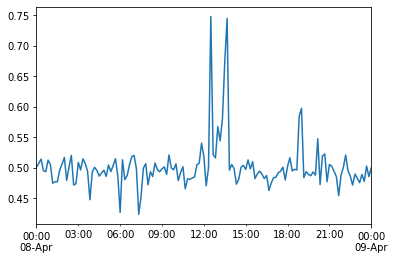

In [9]:
SKIP = False

for ts, tSplice in zip(index, ind):
    if SKIP and (tSplice[-4:] not in times_of_interest):
        continue
    
    T16, T17 = extract_T16T17(tsplice, BB, ncPath, npPath)    
    
    G16, G17, _G17, B
     
    print(f'16, 17, Shape: {T16.shape}, {T17.shape}')
    
    _B = (B - min(B))/(max(B) - min(B))
    _G17n = (_G17 - min(_G17))/(max(_G17) - min(_G17))
    
    AUC = round(sum(_B)/1000,5)
    chart[ts] = AUC
    print("tSplice: ",tSplice,', AUC: ',AUC)
    
    if tSplice[-4:] in times_of_interest:
        #make figures
        jfigout = Path(joint_out,f"G_{SS}_band{BB}_04-{str(day).zfill(2)}-2019_{tSplice}")
        if not jfigout.exists():
            jointplot(G17, G16, jfigout)
            print("created joint plot")


        tfigout = Path(transforms_out, f"G_{SS}_band{BB}_04-{str(day).zfill(2)}-2019_{tSplice}")
        if not tfigout.exists():
            validation_plot(G17, G16, _G17n, _B, AUC, tfigout)
            print("created validation plot")

    if ts.day != day:
        fig2, ax0 = plt.subplots()
        chart.plot(ax=ax0)
        
        fig2.savefig(op.join(DATAPATH,
            f"validation/AUC/G_{SS}_band{BB}_04-{str(day).zfill(2)}-2019_{tSplice}"))
        day+=1
        chart = pd.Series(data=None)